In [2]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (precision_recall_curve, average_precision_score, 
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# 1. Load Preprocessed Data (from Task 1) 
fraud_X_train = pd.read_csv('../Data/processed/fraud_X_train.csv')
fraud_X_test = pd.read_csv('../Data/processed/fraud_X_test.csv')
fraud_y_train = pd.read_csv('../Data/processed/fraud_y_train.csv')
fraud_y_test = pd.read_csv('../Data/processed/fraud_y_test.csv')

cc_X_train = pd.read_csv('../Data/processed/creditcard_X_train.csv')
cc_X_test = pd.read_csv('../Data/processed/creditcard_X_test.csv')
cc_y_train = pd.read_csv('../Data/processed/creditcard_y_train.csv')
cc_y_test = pd.read_csv('../Data/processed/creditcard_y_test.csv')


In [4]:
from sklearn.metrics import log_loss

def optimize_xgb(X, y, n_trials=50):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'gamma': trial.suggest_float('gamma', 0, 2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'scale_pos_weight': len(y[y==0])/len(y[y==1]),
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }
        
        # Train on full training data and evaluate on full training data
        model = XGBClassifier(**params).fit(X, y)
        y_proba = model.predict_proba(X)
        return log_loss(y, y_proba)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest trial for {X.shape[0]} samples:")
    trial = study.best_trial
    print(f"Log Loss: {trial.value:.4f}")
    print("Best params:")
    for key, value in trial.params.items():
        print(f"{key}: {value}")
    
    return study.best_params

# Run optimization
print("Optimizing XGBoost for Fraud Data...")
best_params_fraud = optimize_xgb(fraud_X_train, fraud_y_train)
print("\nOptimizing XGBoost for Credit Card Data...")
best_params_cc = optimize_xgb(cc_X_train, cc_y_train)

[I 2025-07-29 17:58:27,047] A new study created in memory with name: no-name-28f6a29c-ba16-4a81-817d-9d4d184694b7


Optimizing XGBoost for Fraud Data...


Best trial: 0. Best value: 0.101344:   2%|▏         | 1/50 [00:11<09:46, 11.96s/it]

[I 2025-07-29 17:58:39,015] Trial 0 finished with value: 0.10134359878076264 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.17605984367095318, 'subsample': 0.8820285563789241, 'colsample_bytree': 0.7818696988811222, 'gamma': 0.9423140066530178, 'min_child_weight': 5}. Best is trial 0 with value: 0.10134359878076264.


Best trial: 1. Best value: 0.0961675:   4%|▍         | 2/50 [00:31<13:06, 16.38s/it]

[I 2025-07-29 17:58:58,483] Trial 1 finished with value: 0.09616750885555829 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.13874744922570115, 'subsample': 0.7994680897261053, 'colsample_bytree': 0.8334402730713737, 'gamma': 0.11374004336636534, 'min_child_weight': 3}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 1. Best value: 0.0961675:   6%|▌         | 3/50 [00:43<11:08, 14.22s/it]

[I 2025-07-29 17:59:10,130] Trial 2 finished with value: 0.10461350897793784 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.16687173140561062, 'subsample': 0.7623912562866191, 'colsample_bytree': 0.8394335674412932, 'gamma': 0.11538451342097056, 'min_child_weight': 4}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 1. Best value: 0.0961675:   8%|▊         | 4/50 [00:56<10:35, 13.81s/it]

[I 2025-07-29 17:59:23,317] Trial 3 finished with value: 0.09779519459955678 and parameters: {'n_estimators': 178, 'max_depth': 7, 'learning_rate': 0.11146406297187268, 'subsample': 0.8001814837889213, 'colsample_bytree': 0.8754371057771211, 'gamma': 1.4329570703095256, 'min_child_weight': 5}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 1. Best value: 0.0961675:  10%|█         | 5/50 [01:08<09:57, 13.27s/it]

[I 2025-07-29 17:59:35,634] Trial 4 finished with value: 0.10790161052934603 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.14872560070898658, 'subsample': 0.800946244472211, 'colsample_bytree': 0.8996757289891453, 'gamma': 0.8535517222890974, 'min_child_weight': 4}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 1. Best value: 0.0961675:  12%|█▏        | 6/50 [01:21<09:42, 13.24s/it]

[I 2025-07-29 17:59:48,787] Trial 5 finished with value: 0.12951531981800918 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.06751121423286674, 'subsample': 0.8264694443926757, 'colsample_bytree': 0.8385167111177657, 'gamma': 0.2333918688598573, 'min_child_weight': 4}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 1. Best value: 0.0961675:  14%|█▍        | 7/50 [01:42<11:11, 15.61s/it]

[I 2025-07-29 18:00:09,302] Trial 6 finished with value: 0.11947331093486775 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.06889943087704266, 'subsample': 0.7684166919328986, 'colsample_bytree': 0.8763459089781811, 'gamma': 1.9783415166680411, 'min_child_weight': 5}. Best is trial 1 with value: 0.09616750885555829.


Best trial: 7. Best value: 0.0766115:  16%|█▌        | 8/50 [02:14<14:35, 20.85s/it]

[I 2025-07-29 18:00:41,378] Trial 7 finished with value: 0.07661152567129946 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.14543578935195356, 'subsample': 0.7358034802497845, 'colsample_bytree': 0.7297837935571363, 'gamma': 0.214404305201493, 'min_child_weight': 2}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 7. Best value: 0.0766115:  18%|█▊        | 9/50 [02:38<15:02, 22.00s/it]

[I 2025-07-29 18:01:05,905] Trial 8 finished with value: 0.09273767675239385 and parameters: {'n_estimators': 235, 'max_depth': 6, 'learning_rate': 0.14849375319564212, 'subsample': 0.8723349222298807, 'colsample_bytree': 0.7549249111536137, 'gamma': 1.1472009715001115, 'min_child_weight': 2}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 7. Best value: 0.0766115:  20%|██        | 10/50 [02:59<14:17, 21.44s/it]

[I 2025-07-29 18:01:26,079] Trial 9 finished with value: 0.1138237304053266 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.06804138713190769, 'subsample': 0.8316989727130808, 'colsample_bytree': 0.7114097944535316, 'gamma': 0.9265091761476762, 'min_child_weight': 3}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 7. Best value: 0.0766115:  22%|██▏       | 11/50 [03:33<16:29, 25.37s/it]

[I 2025-07-29 18:02:00,373] Trial 10 finished with value: 0.08215807967707198 and parameters: {'n_estimators': 292, 'max_depth': 8, 'learning_rate': 0.10648553053372775, 'subsample': 0.7101705345292544, 'colsample_bytree': 0.700182456235689, 'gamma': 0.5627628612234304, 'min_child_weight': 1}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 7. Best value: 0.0766115:  24%|██▍       | 12/50 [04:12<18:40, 29.48s/it]

[I 2025-07-29 18:02:39,250] Trial 11 finished with value: 0.0820500796886091 and parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.10541484925890633, 'subsample': 0.7025033540162215, 'colsample_bytree': 0.7046787148309366, 'gamma': 0.5090374804159337, 'min_child_weight': 1}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 7. Best value: 0.0766115:  26%|██▌       | 13/50 [04:33<16:39, 27.02s/it]

[I 2025-07-29 18:03:00,621] Trial 12 finished with value: 0.08638820992842307 and parameters: {'n_estimators': 253, 'max_depth': 8, 'learning_rate': 0.10190840454613295, 'subsample': 0.7096279809209508, 'colsample_bytree': 0.7387392396103141, 'gamma': 0.5031912032086506, 'min_child_weight': 1}. Best is trial 7 with value: 0.07661152567129946.


Best trial: 13. Best value: 0.0758787:  28%|██▊       | 14/50 [05:01<16:25, 27.37s/it]

[I 2025-07-29 18:03:28,812] Trial 13 finished with value: 0.07587867215639243 and parameters: {'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.19224086407348734, 'subsample': 0.7333696041298651, 'colsample_bytree': 0.735471600881131, 'gamma': 0.4784062376046058, 'min_child_weight': 2}. Best is trial 13 with value: 0.07587867215639243.


Best trial: 13. Best value: 0.0758787:  30%|███       | 15/50 [05:19<14:20, 24.58s/it]

[I 2025-07-29 18:03:46,929] Trial 14 finished with value: 0.08018627776398407 and parameters: {'n_estimators': 238, 'max_depth': 7, 'learning_rate': 0.19894159620625998, 'subsample': 0.7413745218501985, 'colsample_bytree': 0.7513134347525643, 'gamma': 0.3746150275379358, 'min_child_weight': 2}. Best is trial 13 with value: 0.07587867215639243.


Best trial: 13. Best value: 0.0758787:  32%|███▏      | 16/50 [05:40<13:19, 23.51s/it]

[I 2025-07-29 18:04:07,947] Trial 15 finished with value: 0.07679850959154823 and parameters: {'n_estimators': 266, 'max_depth': 7, 'learning_rate': 0.19909446722075094, 'subsample': 0.7375647823634919, 'colsample_bytree': 0.7857201406791411, 'gamma': 0.009684867291721078, 'min_child_weight': 2}. Best is trial 13 with value: 0.07587867215639243.


Best trial: 13. Best value: 0.0758787:  34%|███▍      | 17/50 [05:55<11:30, 20.91s/it]

[I 2025-07-29 18:04:22,807] Trial 16 finished with value: 0.10887597033360613 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.1778350261615514, 'subsample': 0.7381028609504249, 'colsample_bytree': 0.7394959779343746, 'gamma': 0.6963481790789895, 'min_child_weight': 2}. Best is trial 13 with value: 0.07587867215639243.


Best trial: 13. Best value: 0.0758787:  36%|███▌      | 18/50 [06:24<12:28, 23.38s/it]

[I 2025-07-29 18:04:51,928] Trial 17 finished with value: 0.08693803532453888 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.13172651975074204, 'subsample': 0.7680770279434449, 'colsample_bytree': 0.7276813712761968, 'gamma': 0.3510589513255934, 'min_child_weight': 3}. Best is trial 13 with value: 0.07587867215639243.


Best trial: 18. Best value: 0.0738646:  38%|███▊      | 19/50 [06:59<13:47, 26.71s/it]

[I 2025-07-29 18:05:26,386] Trial 18 finished with value: 0.0738646044945242 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.16405246147546276, 'subsample': 0.7354474953142038, 'colsample_bytree': 0.7679787915015344, 'gamma': 1.400025824187118, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  40%|████      | 20/50 [07:24<13:05, 26.19s/it]

[I 2025-07-29 18:05:51,360] Trial 19 finished with value: 0.09016380824896111 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.1700118935642965, 'subsample': 0.7214445356665445, 'colsample_bytree': 0.8087985049402359, 'gamma': 1.571656425514093, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  42%|████▏     | 21/50 [07:53<13:08, 27.17s/it]

[I 2025-07-29 18:06:20,835] Trial 20 finished with value: 0.07947576579614495 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.15943517237983743, 'subsample': 0.7567741843976009, 'colsample_bytree': 0.7658120673807258, 'gamma': 1.214858951294928, 'min_child_weight': 1}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  44%|████▍     | 22/50 [08:24<13:06, 28.10s/it]

[I 2025-07-29 18:06:51,081] Trial 21 finished with value: 0.07618804743346513 and parameters: {'n_estimators': 274, 'max_depth': 8, 'learning_rate': 0.18739754848025997, 'subsample': 0.7285714936216026, 'colsample_bytree': 0.7257201804507291, 'gamma': 1.638713086190645, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  46%|████▌     | 23/50 [08:50<12:28, 27.73s/it]

[I 2025-07-29 18:07:17,955] Trial 22 finished with value: 0.07955754787275374 and parameters: {'n_estimators': 258, 'max_depth': 8, 'learning_rate': 0.18716516251905205, 'subsample': 0.7861824797323365, 'colsample_bytree': 0.7693545580117198, 'gamma': 1.8226924929402957, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  48%|████▊     | 24/50 [09:21<12:21, 28.50s/it]

[I 2025-07-29 18:07:48,262] Trial 23 finished with value: 0.0754033683095811 and parameters: {'n_estimators': 285, 'max_depth': 8, 'learning_rate': 0.18636794119702144, 'subsample': 0.7302395261082368, 'colsample_bytree': 0.718934823895055, 'gamma': 1.5734923864108423, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  50%|█████     | 25/50 [09:51<12:03, 28.95s/it]

[I 2025-07-29 18:08:18,249] Trial 24 finished with value: 0.08067588686508995 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.18571588341639073, 'subsample': 0.7537704207403222, 'colsample_bytree': 0.7178089990239714, 'gamma': 1.317643852684723, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  52%|█████▏    | 26/50 [10:17<11:15, 28.15s/it]

[I 2025-07-29 18:08:44,540] Trial 25 finished with value: 0.08047986121421634 and parameters: {'n_estimators': 227, 'max_depth': 8, 'learning_rate': 0.15611560060714325, 'subsample': 0.7192253769866985, 'colsample_bytree': 0.8130735328870676, 'gamma': 1.623298745751013, 'min_child_weight': 1}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  54%|█████▍    | 27/50 [10:55<11:54, 31.08s/it]

[I 2025-07-29 18:09:22,452] Trial 26 finished with value: 0.07994614714313165 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.16413169234798328, 'subsample': 0.781924470593501, 'colsample_bytree': 0.7554485697828436, 'gamma': 1.0960733774604277, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  56%|█████▌    | 28/50 [11:26<11:26, 31.22s/it]

[I 2025-07-29 18:09:54,009] Trial 27 finished with value: 0.10786626636976045 and parameters: {'n_estimators': 267, 'max_depth': 6, 'learning_rate': 0.051747859948771444, 'subsample': 0.7482151668675652, 'colsample_bytree': 0.7738100722631757, 'gamma': 1.4237090080165418, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  58%|█████▊    | 29/50 [11:51<10:10, 29.09s/it]

[I 2025-07-29 18:10:18,139] Trial 28 finished with value: 0.08286388133753514 and parameters: {'n_estimators': 204, 'max_depth': 8, 'learning_rate': 0.18992368301653176, 'subsample': 0.8259837199173284, 'colsample_bytree': 0.7937635764643076, 'gamma': 1.865726465798389, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  60%|██████    | 30/50 [12:19<09:34, 28.74s/it]

[I 2025-07-29 18:10:46,051] Trial 29 finished with value: 0.08129664709852664 and parameters: {'n_estimators': 247, 'max_depth': 7, 'learning_rate': 0.17666243148450256, 'subsample': 0.8944176957474392, 'colsample_bytree': 0.7445406552495428, 'gamma': 0.7729238474078949, 'min_child_weight': 1}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  62%|██████▏   | 31/50 [12:52<09:30, 30.02s/it]

[I 2025-07-29 18:11:19,066] Trial 30 finished with value: 0.08118507051974058 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.12247118916374251, 'subsample': 0.7207925342965867, 'colsample_bytree': 0.7168159589036353, 'gamma': 1.0109662564904207, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  64%|██████▍   | 32/50 [13:20<08:54, 29.69s/it]

[I 2025-07-29 18:11:47,996] Trial 31 finished with value: 0.07727347725202936 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.18150380483486603, 'subsample': 0.7210705340104401, 'colsample_bytree': 0.7277790447993392, 'gamma': 1.6637296571901121, 'min_child_weight': 2}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  66%|██████▌   | 33/50 [13:51<08:28, 29.92s/it]

[I 2025-07-29 18:12:18,433] Trial 32 finished with value: 0.0750604629249971 and parameters: {'n_estimators': 285, 'max_depth': 8, 'learning_rate': 0.19404035485817647, 'subsample': 0.7271555323714847, 'colsample_bytree': 0.7263717614207476, 'gamma': 1.4973519921382392, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  68%|██████▊   | 34/50 [14:22<08:05, 30.37s/it]

[I 2025-07-29 18:12:49,844] Trial 33 finished with value: 0.07647759407734517 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.193866165758711, 'subsample': 0.7801241791589216, 'colsample_bytree': 0.7602329583018934, 'gamma': 1.4715340366063023, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  70%|███████   | 35/50 [14:54<07:41, 30.75s/it]

[I 2025-07-29 18:13:21,481] Trial 34 finished with value: 0.0830189554080477 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.17144758783831568, 'subsample': 0.70206370521813, 'colsample_bytree': 0.7799294740955626, 'gamma': 1.3135649273470684, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  72%|███████▏  | 36/50 [15:28<07:26, 31.86s/it]

[I 2025-07-29 18:13:55,945] Trial 35 finished with value: 0.07541480910665951 and parameters: {'n_estimators': 280, 'max_depth': 8, 'learning_rate': 0.17895793379338357, 'subsample': 0.7491508340588623, 'colsample_bytree': 0.7423776073287652, 'gamma': 1.3169665984067602, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  74%|███████▍  | 37/50 [15:55<06:35, 30.41s/it]

[I 2025-07-29 18:14:22,954] Trial 36 finished with value: 0.1002982646684153 and parameters: {'n_estimators': 277, 'max_depth': 4, 'learning_rate': 0.15719756819432132, 'subsample': 0.7485728375355194, 'colsample_bytree': 0.74664195697194, 'gamma': 1.734885945456183, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  76%|███████▌  | 38/50 [16:20<05:44, 28.73s/it]

[I 2025-07-29 18:14:47,768] Trial 37 finished with value: 0.08670399040948545 and parameters: {'n_estimators': 178, 'max_depth': 8, 'learning_rate': 0.17292478195117064, 'subsample': 0.7661163616074016, 'colsample_bytree': 0.7132811671849595, 'gamma': 1.522934555641158, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  78%|███████▊  | 39/50 [16:35<04:31, 24.65s/it]

[I 2025-07-29 18:15:02,918] Trial 38 finished with value: 0.10777539699678647 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.13728387051791707, 'subsample': 0.7965337218707133, 'colsample_bytree': 0.7925016626646764, 'gamma': 1.3328227224856768, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  80%|████████  | 40/50 [17:04<04:17, 25.73s/it]

[I 2025-07-29 18:15:31,150] Trial 39 finished with value: 0.07782411301209018 and parameters: {'n_estimators': 242, 'max_depth': 8, 'learning_rate': 0.16447964919094354, 'subsample': 0.7487759682984569, 'colsample_bytree': 0.8564445537423323, 'gamma': 1.2128242687026094, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  82%|████████▏ | 41/50 [17:29<03:51, 25.67s/it]

[I 2025-07-29 18:15:56,687] Trial 40 finished with value: 0.08568381154757251 and parameters: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.17881940005895144, 'subsample': 0.7107383698368522, 'colsample_bytree': 0.8210961619674318, 'gamma': 1.3909541181784646, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  84%|████████▍ | 42/50 [18:03<03:44, 28.04s/it]

[I 2025-07-29 18:16:30,272] Trial 41 finished with value: 0.07474634931323101 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.19271813627761478, 'subsample': 0.7260310236274125, 'colsample_bytree': 0.7365323083561073, 'gamma': 1.5161089537198704, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  86%|████████▌ | 43/50 [18:32<03:18, 28.31s/it]

[I 2025-07-29 18:16:59,210] Trial 42 finished with value: 0.07677476506423637 and parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.19821396516169007, 'subsample': 0.7287811780463348, 'colsample_bytree': 0.7227941106385909, 'gamma': 1.7453268245771962, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  88%|████████▊ | 44/50 [19:00<02:49, 28.26s/it]

[I 2025-07-29 18:17:27,362] Trial 43 finished with value: 0.08069304402859653 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.18193115906472096, 'subsample': 0.7608934204523052, 'colsample_bytree': 0.735713451667576, 'gamma': 1.9801477073782212, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  90%|█████████ | 45/50 [19:33<02:28, 29.72s/it]

[I 2025-07-29 18:18:00,468] Trial 44 finished with value: 0.08980646395148946 and parameters: {'n_estimators': 291, 'max_depth': 8, 'learning_rate': 0.084136577831483, 'subsample': 0.7431514764546805, 'colsample_bytree': 0.7609302420059283, 'gamma': 1.4875473049293653, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  92%|█████████▏| 46/50 [20:01<01:57, 29.33s/it]

[I 2025-07-29 18:18:28,901] Trial 45 finished with value: 0.07697240796138329 and parameters: {'n_estimators': 258, 'max_depth': 8, 'learning_rate': 0.1930001383758581, 'subsample': 0.8576469640236399, 'colsample_bytree': 0.704909387653362, 'gamma': 1.2256763585768575, 'min_child_weight': 3}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  94%|█████████▍| 47/50 [20:36<01:32, 30.79s/it]

[I 2025-07-29 18:19:03,085] Trial 46 finished with value: 0.07541422276851843 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.1834175251253911, 'subsample': 0.7288869190069363, 'colsample_bytree': 0.7445478200517457, 'gamma': 1.0861707032353372, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  96%|█████████▌| 48/50 [21:09<01:03, 31.72s/it]

[I 2025-07-29 18:19:36,985] Trial 47 finished with value: 0.08221741903538103 and parameters: {'n_estimators': 292, 'max_depth': 7, 'learning_rate': 0.1850447377325136, 'subsample': 0.7147629812125245, 'colsample_bytree': 0.7508251974671531, 'gamma': 1.0884793981840957, 'min_child_weight': 5}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646:  98%|█████████▊| 49/50 [21:32<00:29, 29.05s/it]

[I 2025-07-29 18:19:59,785] Trial 48 finished with value: 0.1087663925051287 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.15126522986907356, 'subsample': 0.7307504404168328, 'colsample_bytree': 0.7322348188715073, 'gamma': 0.9286700306423545, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.


Best trial: 18. Best value: 0.0738646: 100%|██████████| 50/50 [21:51<00:00, 26.23s/it]
[I 2025-07-29 18:20:18,728] A new study created in memory with name: no-name-813581c1-1882-47a7-9b1c-07143d46d65c


[I 2025-07-29 18:20:18,702] Trial 49 finished with value: 0.09075957103101845 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.1662429970584721, 'subsample': 0.8123257677806608, 'colsample_bytree': 0.7092702681261625, 'gamma': 1.5516426084412152, 'min_child_weight': 4}. Best is trial 18 with value: 0.0738646044945242.

Best trial for 219136 samples:
Log Loss: 0.0739
Best params:
n_estimators: 300
max_depth: 8
learning_rate: 0.16405246147546276
subsample: 0.7354474953142038
colsample_bytree: 0.7679787915015344
gamma: 1.400025824187118
min_child_weight: 2

Optimizing XGBoost for Credit Card Data...


Best trial: 0. Best value: 0.0318772:   2%|▏         | 1/50 [00:00<00:29,  1.65it/s]

[I 2025-07-29 18:20:19,335] Trial 0 finished with value: 0.03187719149678259 and parameters: {'n_estimators': 264, 'max_depth': 7, 'learning_rate': 0.09083219621977276, 'subsample': 0.8080441434844439, 'colsample_bytree': 0.8524178920050831, 'gamma': 1.0122793578199996, 'min_child_weight': 2}. Best is trial 0 with value: 0.03187719149678259.


Best trial: 0. Best value: 0.0318772:   4%|▍         | 2/50 [00:01<00:23,  2.02it/s]

[I 2025-07-29 18:20:19,750] Trial 1 finished with value: 0.05140702279174504 and parameters: {'n_estimators': 123, 'max_depth': 3, 'learning_rate': 0.09046255140373796, 'subsample': 0.8114852364929767, 'colsample_bytree': 0.8708580560002526, 'gamma': 1.1747814083881225, 'min_child_weight': 4}. Best is trial 0 with value: 0.03187719149678259.


Best trial: 0. Best value: 0.0318772:   6%|▌         | 3/50 [00:01<00:20,  2.29it/s]

[I 2025-07-29 18:20:20,116] Trial 2 finished with value: 0.04383720594662639 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.13332885501531028, 'subsample': 0.7508823981239111, 'colsample_bytree': 0.8898129201685108, 'gamma': 1.4783125337888943, 'min_child_weight': 3}. Best is trial 0 with value: 0.03187719149678259.


Best trial: 0. Best value: 0.0318772:   8%|▊         | 4/50 [00:01<00:22,  2.03it/s]

[I 2025-07-29 18:20:20,693] Trial 3 finished with value: 0.06370550499854746 and parameters: {'n_estimators': 231, 'max_depth': 5, 'learning_rate': 0.07340360982739035, 'subsample': 0.8765865523882318, 'colsample_bytree': 0.8118938472128254, 'gamma': 1.9759572383616022, 'min_child_weight': 4}. Best is trial 0 with value: 0.03187719149678259.


Best trial: 4. Best value: 0.0289457:  10%|█         | 5/50 [00:02<00:26,  1.67it/s]

[I 2025-07-29 18:20:21,473] Trial 4 finished with value: 0.02894573827753836 and parameters: {'n_estimators': 182, 'max_depth': 4, 'learning_rate': 0.06564602833112006, 'subsample': 0.7001834475645962, 'colsample_bytree': 0.8834467828137689, 'gamma': 0.4685382784797003, 'min_child_weight': 2}. Best is trial 4 with value: 0.02894573827753836.


Best trial: 4. Best value: 0.0289457:  12%|█▏        | 6/50 [00:03<00:24,  1.78it/s]

[I 2025-07-29 18:20:21,973] Trial 5 finished with value: 0.047470676243708224 and parameters: {'n_estimators': 184, 'max_depth': 6, 'learning_rate': 0.14324894836718657, 'subsample': 0.8169977897307721, 'colsample_bytree': 0.7930500147339794, 'gamma': 1.860722587054317, 'min_child_weight': 2}. Best is trial 4 with value: 0.02894573827753836.


Best trial: 4. Best value: 0.0289457:  14%|█▍        | 7/50 [00:03<00:24,  1.75it/s]

[I 2025-07-29 18:20:22,567] Trial 6 finished with value: 0.036881908573340526 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.14207503935303678, 'subsample': 0.8719073276771533, 'colsample_bytree': 0.7437245829260541, 'gamma': 1.4241120800437361, 'min_child_weight': 1}. Best is trial 4 with value: 0.02894573827753836.


Best trial: 4. Best value: 0.0289457:  16%|█▌        | 8/50 [00:04<00:25,  1.64it/s]

[I 2025-07-29 18:20:23,257] Trial 7 finished with value: 0.038805174802136515 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.11304079824033214, 'subsample': 0.7210731786483494, 'colsample_bytree': 0.8174474839578851, 'gamma': 0.7279024715716595, 'min_child_weight': 5}. Best is trial 4 with value: 0.02894573827753836.


Best trial: 8. Best value: 0.0189428:  18%|█▊        | 9/50 [00:05<00:26,  1.54it/s]

[I 2025-07-29 18:20:23,998] Trial 8 finished with value: 0.018942786689007413 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.09524263626634102, 'subsample': 0.810799855134727, 'colsample_bytree': 0.7775328650891875, 'gamma': 0.38421908221465917, 'min_child_weight': 2}. Best is trial 8 with value: 0.018942786689007413.


Best trial: 8. Best value: 0.0189428:  20%|██        | 10/50 [00:05<00:26,  1.49it/s]

[I 2025-07-29 18:20:24,714] Trial 9 finished with value: 0.07171774024433611 and parameters: {'n_estimators': 141, 'max_depth': 4, 'learning_rate': 0.05517477602126672, 'subsample': 0.7858144189061457, 'colsample_bytree': 0.7164669506809364, 'gamma': 0.21964935603611457, 'min_child_weight': 5}. Best is trial 8 with value: 0.018942786689007413.


Best trial: 10. Best value: 0.00500124:  22%|██▏       | 11/50 [00:06<00:27,  1.40it/s]

[I 2025-07-29 18:20:25,535] Trial 10 finished with value: 0.005001240878919532 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.19083585978251996, 'subsample': 0.853420701352235, 'colsample_bytree': 0.7700106241713471, 'gamma': 0.009781674380997307, 'min_child_weight': 1}. Best is trial 10 with value: 0.005001240878919532.


Best trial: 10. Best value: 0.00500124:  24%|██▍       | 12/50 [00:07<00:28,  1.35it/s]

[I 2025-07-29 18:20:26,323] Trial 11 finished with value: 0.0050122422163930225 and parameters: {'n_estimators': 216, 'max_depth': 6, 'learning_rate': 0.19981765439608629, 'subsample': 0.846407526342933, 'colsample_bytree': 0.7652351026495244, 'gamma': 0.0038823046410806448, 'min_child_weight': 1}. Best is trial 10 with value: 0.005001240878919532.


Best trial: 12. Best value: 0.00484147:  26%|██▌       | 13/50 [00:08<00:29,  1.25it/s]

[I 2025-07-29 18:20:27,261] Trial 12 finished with value: 0.004841470841834268 and parameters: {'n_estimators': 236, 'max_depth': 7, 'learning_rate': 0.19944008334278562, 'subsample': 0.8489856782326132, 'colsample_bytree': 0.7555296087810525, 'gamma': 0.01146887838715454, 'min_child_weight': 1}. Best is trial 12 with value: 0.004841470841834268.


Best trial: 13. Best value: 0.00448897:  28%|██▊       | 14/50 [00:09<00:32,  1.10it/s]

[I 2025-07-29 18:20:28,431] Trial 13 finished with value: 0.00448897182355546 and parameters: {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.19400372923812143, 'subsample': 0.8978799950358755, 'colsample_bytree': 0.7057902648625826, 'gamma': 0.019502545482357816, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  30%|███       | 15/50 [00:10<00:30,  1.13it/s]

[I 2025-07-29 18:20:29,256] Trial 14 finished with value: 0.020711346911956804 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.16757535460694117, 'subsample': 0.892207202754706, 'colsample_bytree': 0.7070990319649155, 'gamma': 0.6189368168001484, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  32%|███▏      | 16/50 [00:11<00:29,  1.16it/s]

[I 2025-07-29 18:20:30,056] Trial 15 finished with value: 0.016290258744604304 and parameters: {'n_estimators': 254, 'max_depth': 7, 'learning_rate': 0.17314786690973386, 'subsample': 0.8997926332975569, 'colsample_bytree': 0.7350276856328084, 'gamma': 0.23643163936624823, 'min_child_weight': 3}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  34%|███▍      | 17/50 [00:12<00:27,  1.21it/s]

[I 2025-07-29 18:20:30,802] Trial 16 finished with value: 0.022944661122649826 and parameters: {'n_estimators': 249, 'max_depth': 7, 'learning_rate': 0.16628961317794644, 'subsample': 0.8413160274223551, 'colsample_bytree': 0.7382352241475741, 'gamma': 0.7885543491542013, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  36%|███▌      | 18/50 [00:12<00:24,  1.29it/s]

[I 2025-07-29 18:20:31,465] Trial 17 finished with value: 0.017801389800241284 and parameters: {'n_estimators': 160, 'max_depth': 8, 'learning_rate': 0.1804704650957813, 'subsample': 0.8666657829495497, 'colsample_bytree': 0.710008525473261, 'gamma': 0.25385115542197956, 'min_child_weight': 3}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  38%|███▊      | 19/50 [00:13<00:24,  1.28it/s]

[I 2025-07-29 18:20:32,245] Trial 18 finished with value: 0.019033455942435887 and parameters: {'n_estimators': 285, 'max_depth': 7, 'learning_rate': 0.15493338307300442, 'subsample': 0.836235996690868, 'colsample_bytree': 0.7464015879567781, 'gamma': 0.5062238310991488, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  40%|████      | 20/50 [00:14<00:22,  1.36it/s]

[I 2025-07-29 18:20:32,887] Trial 19 finished with value: 0.024373760577175593 and parameters: {'n_estimators': 189, 'max_depth': 8, 'learning_rate': 0.19844457548693323, 'subsample': 0.7748310397109244, 'colsample_bytree': 0.832751163761074, 'gamma': 0.9033746512028232, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  42%|████▏     | 21/50 [00:15<00:24,  1.16it/s]

[I 2025-07-29 18:20:34,040] Trial 20 finished with value: 0.013967425535711061 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.18456108328537635, 'subsample': 0.8825723607634688, 'colsample_bytree': 0.7001823513703597, 'gamma': 0.005532692663580158, 'min_child_weight': 3}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  44%|████▍     | 22/50 [00:16<00:23,  1.21it/s]

[I 2025-07-29 18:20:34,776] Trial 21 finished with value: 0.00638198406547333 and parameters: {'n_estimators': 220, 'max_depth': 6, 'learning_rate': 0.18865805357951207, 'subsample': 0.8584729278076701, 'colsample_bytree': 0.7709403411100965, 'gamma': 0.08486934843437674, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  46%|████▌     | 23/50 [00:16<00:22,  1.20it/s]

[I 2025-07-29 18:20:35,628] Trial 22 finished with value: 0.00980145539302417 and parameters: {'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.15810062065392014, 'subsample': 0.830175816929921, 'colsample_bytree': 0.7860338933041845, 'gamma': 0.20846219986866693, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  48%|████▊     | 24/50 [00:17<00:20,  1.27it/s]

[I 2025-07-29 18:20:36,317] Trial 23 finished with value: 0.016214906305971187 and parameters: {'n_estimators': 202, 'max_depth': 7, 'learning_rate': 0.18767810418936068, 'subsample': 0.8564611819076583, 'colsample_bytree': 0.7545346941585276, 'gamma': 0.36294655110609786, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  50%|█████     | 25/50 [00:18<00:20,  1.23it/s]

[I 2025-07-29 18:20:37,180] Trial 24 finished with value: 0.007202444107929463 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.19826978160540945, 'subsample': 0.8885450503936673, 'colsample_bytree': 0.727988198981445, 'gamma': 0.11563508587665283, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  52%|█████▏    | 26/50 [00:19<00:18,  1.28it/s]

[I 2025-07-29 18:20:37,900] Trial 25 finished with value: 0.0204681288987929 and parameters: {'n_estimators': 229, 'max_depth': 6, 'learning_rate': 0.17857817958184086, 'subsample': 0.8284560554556679, 'colsample_bytree': 0.7239528358841795, 'gamma': 0.5838530403353962, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  54%|█████▍    | 27/50 [00:20<00:18,  1.25it/s]

[I 2025-07-29 18:20:38,729] Trial 26 finished with value: 0.014791670850586342 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.11481230924798716, 'subsample': 0.8533106002407789, 'colsample_bytree': 0.7626101603532001, 'gamma': 0.34097816891107574, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  56%|█████▌    | 28/50 [00:20<00:17,  1.26it/s]

[I 2025-07-29 18:20:39,505] Trial 27 finished with value: 0.023353406958454878 and parameters: {'n_estimators': 244, 'max_depth': 8, 'learning_rate': 0.1564053407828834, 'subsample': 0.7874859411598577, 'colsample_bytree': 0.8046715815869918, 'gamma': 0.14407625923861817, 'min_child_weight': 4}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  58%|█████▊    | 29/50 [00:21<00:16,  1.25it/s]

[I 2025-07-29 18:20:40,317] Trial 28 finished with value: 0.009497558391888148 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.19076886800668716, 'subsample': 0.866703094846524, 'colsample_bytree': 0.7793580352359821, 'gamma': 0.052790767550234034, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  60%|██████    | 30/50 [00:22<00:15,  1.26it/s]

[I 2025-07-29 18:20:41,108] Trial 29 finished with value: 0.03251901734934408 and parameters: {'n_estimators': 264, 'max_depth': 7, 'learning_rate': 0.16931561475024454, 'subsample': 0.8988825612788065, 'colsample_bytree': 0.8219531096070205, 'gamma': 1.21500516770873, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  62%|██████▏   | 31/50 [00:23<00:14,  1.28it/s]

[I 2025-07-29 18:20:41,852] Trial 30 finished with value: 0.015088247385346866 and parameters: {'n_estimators': 195, 'max_depth': 7, 'learning_rate': 0.1782850720560543, 'subsample': 0.8254395502748528, 'colsample_bytree': 0.8375658472371899, 'gamma': 0.33397528306579066, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  64%|██████▍   | 32/50 [00:23<00:14,  1.25it/s]

[I 2025-07-29 18:20:42,699] Trial 31 finished with value: 0.005040146858190593 and parameters: {'n_estimators': 215, 'max_depth': 6, 'learning_rate': 0.1977936284770605, 'subsample': 0.8458459358474835, 'colsample_bytree': 0.7629747827905599, 'gamma': 0.0236308095813714, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  66%|██████▌   | 33/50 [00:24<00:14,  1.17it/s]

[I 2025-07-29 18:20:43,682] Trial 32 finished with value: 0.004873428815940762 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.19989618481125687, 'subsample': 0.8463992005198093, 'colsample_bytree': 0.7565515256214196, 'gamma': 0.020726197871672188, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  68%|██████▊   | 34/50 [00:25<00:13,  1.22it/s]

[I 2025-07-29 18:20:44,414] Trial 33 finished with value: 0.0088518405625859 and parameters: {'n_estimators': 236, 'max_depth': 5, 'learning_rate': 0.18866501175367084, 'subsample': 0.7944269098561099, 'colsample_bytree': 0.7520423628784294, 'gamma': 0.18529808833215541, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  70%|███████   | 35/50 [00:26<00:11,  1.27it/s]

[I 2025-07-29 18:20:45,141] Trial 34 finished with value: 0.03026083966557175 and parameters: {'n_estimators': 266, 'max_depth': 3, 'learning_rate': 0.1897873717130725, 'subsample': 0.7642590333497629, 'colsample_bytree': 0.7988340405733498, 'gamma': 1.1175962521341418, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  72%|███████▏  | 36/50 [00:27<00:11,  1.18it/s]

[I 2025-07-29 18:20:46,129] Trial 35 finished with value: 0.018017692294741892 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.1768151380647403, 'subsample': 0.8783869166445075, 'colsample_bytree': 0.8616264844993574, 'gamma': 0.41533632440270596, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  74%|███████▍  | 37/50 [00:28<00:10,  1.20it/s]

[I 2025-07-29 18:20:46,933] Trial 36 finished with value: 0.04479299891585214 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.12583289282007254, 'subsample': 0.8026840026753844, 'colsample_bytree': 0.7228531193303671, 'gamma': 1.7117177309062137, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  76%|███████▌  | 38/50 [00:28<00:09,  1.24it/s]

[I 2025-07-29 18:20:47,655] Trial 37 finished with value: 0.009887929289111757 and parameters: {'n_estimators': 103, 'max_depth': 5, 'learning_rate': 0.16399927521738572, 'subsample': 0.8660088721602877, 'colsample_bytree': 0.7888229309338296, 'gamma': 0.14098704905725118, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  78%|███████▊  | 39/50 [00:29<00:09,  1.19it/s]

[I 2025-07-29 18:20:48,577] Trial 38 finished with value: 0.026275411197443428 and parameters: {'n_estimators': 176, 'max_depth': 8, 'learning_rate': 0.1452207686080375, 'subsample': 0.8201475123189527, 'colsample_bytree': 0.753815505024478, 'gamma': 0.30183196070265805, 'min_child_weight': 4}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  80%|████████  | 40/50 [00:30<00:09,  1.08it/s]

[I 2025-07-29 18:20:49,701] Trial 39 finished with value: 0.021200564361579334 and parameters: {'n_estimators': 224, 'max_depth': 3, 'learning_rate': 0.08377040506406389, 'subsample': 0.8800633704878014, 'colsample_bytree': 0.734151329687291, 'gamma': 0.48021136314855833, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  82%|████████▏ | 41/50 [00:31<00:08,  1.11it/s]

[I 2025-07-29 18:20:50,555] Trial 40 finished with value: 0.02101554891682999 and parameters: {'n_estimators': 237, 'max_depth': 5, 'learning_rate': 0.19403227609429613, 'subsample': 0.8092732349411585, 'colsample_bytree': 0.7709157718890852, 'gamma': 0.6313623523110925, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  84%|████████▍ | 42/50 [00:32<00:07,  1.10it/s]

[I 2025-07-29 18:20:51,474] Trial 41 finished with value: 0.0049925594614342325 and parameters: {'n_estimators': 216, 'max_depth': 6, 'learning_rate': 0.1985512101640827, 'subsample': 0.8444358045740774, 'colsample_bytree': 0.7645367901132971, 'gamma': 0.016046941135076927, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  86%|████████▌ | 43/50 [00:33<00:06,  1.14it/s]

[I 2025-07-29 18:20:52,285] Trial 42 finished with value: 0.007244929972690108 and parameters: {'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.18382379529889878, 'subsample': 0.8503963113975799, 'colsample_bytree': 0.7788403794964271, 'gamma': 0.1169247680443282, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  88%|████████▊ | 44/50 [00:34<00:05,  1.13it/s]

[I 2025-07-29 18:20:53,186] Trial 43 finished with value: 0.004976224273259246 and parameters: {'n_estimators': 231, 'max_depth': 6, 'learning_rate': 0.1931757465590761, 'subsample': 0.8383936450596172, 'colsample_bytree': 0.7447287836885707, 'gamma': 0.013409671432311787, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  90%|█████████ | 45/50 [00:35<00:04,  1.19it/s]

[I 2025-07-29 18:20:53,922] Trial 44 finished with value: 0.00852016085457362 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.1933718477730279, 'subsample': 0.8384620235187807, 'colsample_bytree': 0.7433343850841915, 'gamma': 0.16410345937671456, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  92%|█████████▏| 46/50 [00:36<00:03,  1.19it/s]

[I 2025-07-29 18:20:54,767] Trial 45 finished with value: 0.01349507314377393 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.17335521099082138, 'subsample': 0.8140603734059729, 'colsample_bytree': 0.7166293382372927, 'gamma': 0.26434001620556313, 'min_child_weight': 2}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  94%|█████████▍| 47/50 [00:36<00:02,  1.17it/s]

[I 2025-07-29 18:20:55,655] Trial 46 finished with value: 0.006636048931654861 and parameters: {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.19962796005321434, 'subsample': 0.7202268489317853, 'colsample_bytree': 0.7569585828451738, 'gamma': 0.09881246338710493, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  96%|█████████▌| 48/50 [00:37<00:01,  1.17it/s]

[I 2025-07-29 18:20:56,514] Trial 47 finished with value: 0.035036775476310775 and parameters: {'n_estimators': 234, 'max_depth': 6, 'learning_rate': 0.18132285427664174, 'subsample': 0.8344644406769183, 'colsample_bytree': 0.7316828406269987, 'gamma': 1.3827006461555436, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897:  98%|█████████▊| 49/50 [00:38<00:00,  1.12it/s]

[I 2025-07-29 18:20:57,479] Trial 48 finished with value: 0.018946482694897213 and parameters: {'n_estimators': 261, 'max_depth': 5, 'learning_rate': 0.09635381971065067, 'subsample': 0.8627752016307029, 'colsample_bytree': 0.7432646483884935, 'gamma': 0.26157526589196645, 'min_child_weight': 3}. Best is trial 13 with value: 0.00448897182355546.


Best trial: 13. Best value: 0.00448897: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]

[I 2025-07-29 18:20:58,540] Trial 49 finished with value: 0.004820075363691569 and parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.18295957047127745, 'subsample': 0.819581634529638, 'colsample_bytree': 0.8948781101838368, 'gamma': 0.017335465938768217, 'min_child_weight': 1}. Best is trial 13 with value: 0.00448897182355546.

Best trial for 756 samples:
Log Loss: 0.0045
Best params:
n_estimators: 252
max_depth: 8
learning_rate: 0.19400372923812143
subsample: 0.8978799950358755
colsample_bytree: 0.7057902648625826
gamma: 0.019502545482357816
min_child_weight: 1


In [5]:
from sklearn.metrics import log_loss, average_precision_score, f1_score

def evaluate(model, X, y, model_name, dataset_name):
    # Fit model on full data
    model.fit(X, y)
    
    # Get predictions
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    results = {}
    
    if y_proba is not None:
        results['log_loss'] = (log_loss(y, y_proba), 0)
        results['average_precision'] = (average_precision_score(y, y_proba[:, 1]), 0)
    else:
        results['log_loss'] = (float('nan'), 0)
        results['average_precision'] = (float('nan'), 0)
    
    results['f1'] = (f1_score(y, y_pred), 0)
    
    # Print results
    print(f"\n{model_name} - {dataset_name} Evaluation Results:")
    if y_proba is not None:
        print(f"Log Loss: {results['log_loss'][0]:.4f}")
        print(f"Average Precision: {results['average_precision'][0]:.4f}")
    print(f"F1-Score: {results['f1'][0]:.4f}")
    
    # Store metrics in model object for reference
    model.eval_results_ = results
    return model

In [ ]:

# 4. Train and Evaluate Models with Cross-Validation
# Fraud Data Models

best_params_fraud_xgb = {
"n_estimators": 252,
"max_depth": 8,
"learning_rate": 0.19400372923812143,
"subsample": 0.8978799950358755,
"colsample_bytree": 0.7057902648625826,
"gamma": 0.019502545482357816,
"min_child_weight": 1}


best_params_cc_xgb = {
"n_estimators": 300,
"max_depth": 8,
"learning_rate": 0.16405246147546276,
"subsample": 0.7354474953142038,
"colsample_bytree": 0.7679787915015344,
"gamma": 1.400025824187118,
"min_child_weight": 2
}

print("\n" + "="*50)
print("FRAUD DATA MODELING")
print("="*50)

lr_fraud = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_fraud = evaluate(lr_fraud, fraud_X_train, fraud_y_train, 
                        "Logistic Regression", "Fraud Data")

xgb_fraud = XGBClassifier(**best_params_fraud, random_state=42)
xgb_fraud = evaluate(xgb_fraud, fraud_X_train, fraud_y_train,
                            "XGBoost", "Fraud Data")

# Credit Card Data Models
print("\n" + "="*50)
print("CREDIT CARD DATA MODELING")
print("="*50)

lr_cc = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_cc = evaluate(lr_cc, cc_X_train, cc_y_train,
                        "Logistic Regression", "Credit Card Data")

xgb_cc = XGBClassifier(**best_params_cc, random_state=42)
xgb_cc = evaluate(xgb_cc, cc_X_train, cc_y_train,
                        "XGBoost", "Credit Card Data")



FRAUD DATA MODELING


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Logistic Regression - Fraud Data Evaluation Results:
Log Loss: 0.1188
Average Precision: 0.9868
F1-Score: 0.9705

XGBoost - Fraud Data Evaluation Results:
Log Loss: 0.0739
Average Precision: 0.9960
F1-Score: 0.9759

CREDIT CARD DATA MODELING

Logistic Regression - Credit Card Data Evaluation Results:
Log Loss: 0.1238
Average Precision: 0.9911
F1-Score: 0.9441


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



XGBoost - Credit Card Data Evaluation Results:
Log Loss: 0.0045
Average Precision: 1.0000
F1-Score: 1.0000


In [7]:

# 5. Final Evaluation on Test Set
def final_evaluation(model, X_test, y_test, model_name, dataset_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    ap_score = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'{model_name} (AP={ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve ({dataset_name})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legit', 'Fraud'], 
                yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTest Set Classification Report ({model_name} - {dataset_name}):")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))
    
    return {
        'avg_precision': ap_score,
        'f1_score': f1
    }



FINAL TEST SET EVALUATION

Fraud Data Results:


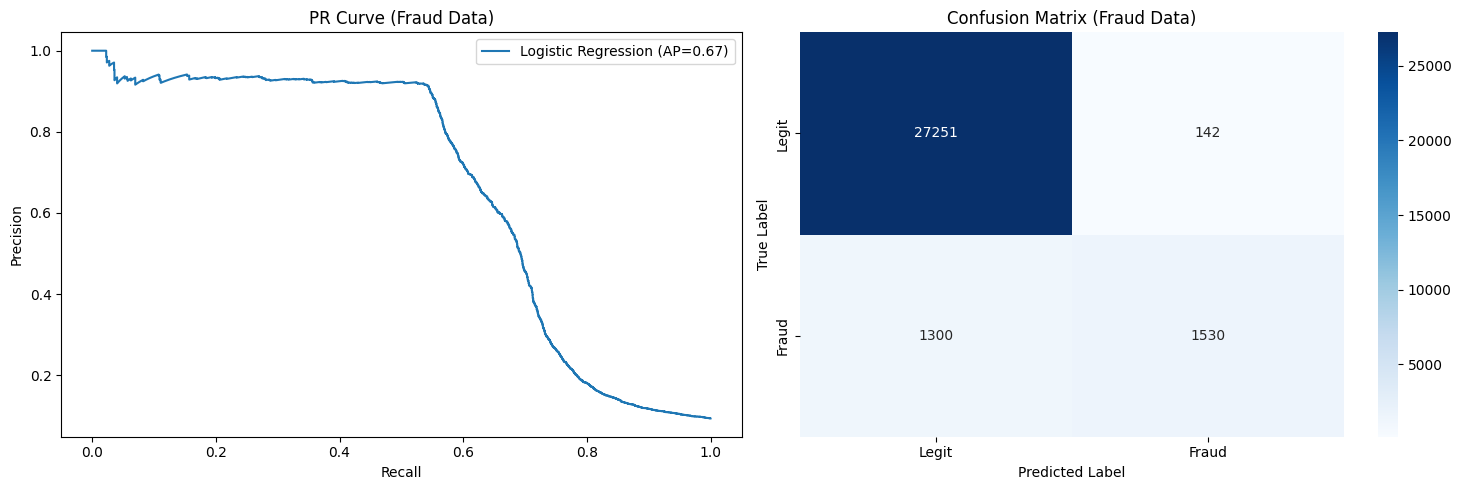


Test Set Classification Report (Logistic Regression - Fraud Data):
              precision    recall  f1-score   support

       Legit       0.95      0.99      0.97     27393
       Fraud       0.92      0.54      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



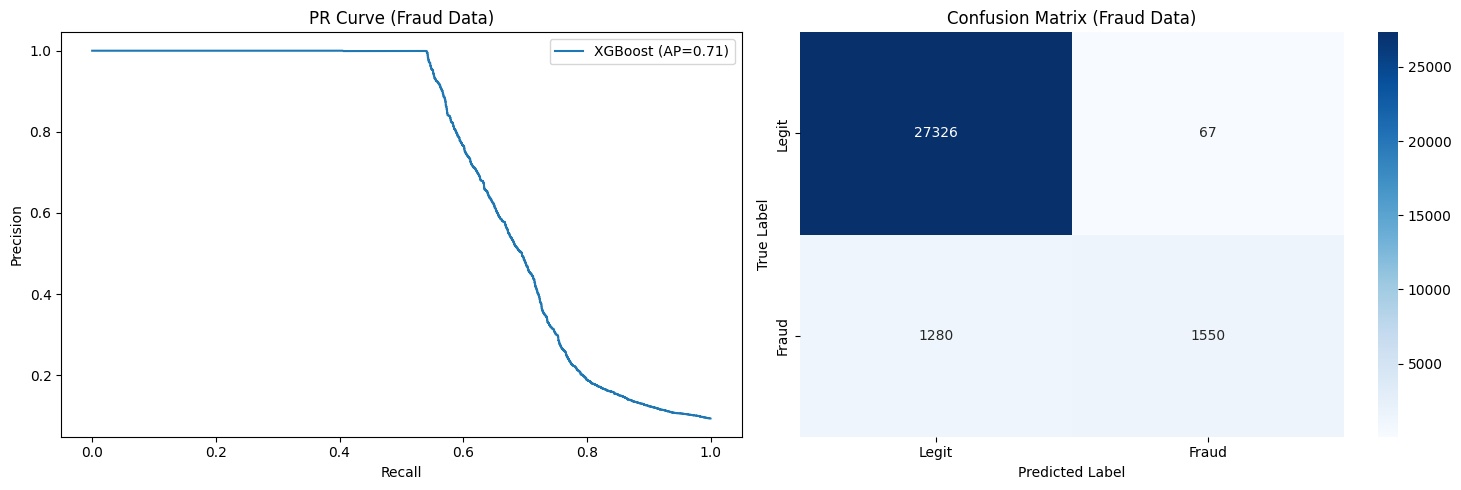


Test Set Classification Report (XGBoost - Fraud Data):
              precision    recall  f1-score   support

       Legit       0.96      1.00      0.98     27393
       Fraud       0.96      0.55      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.96      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223


Credit Card Data Results:


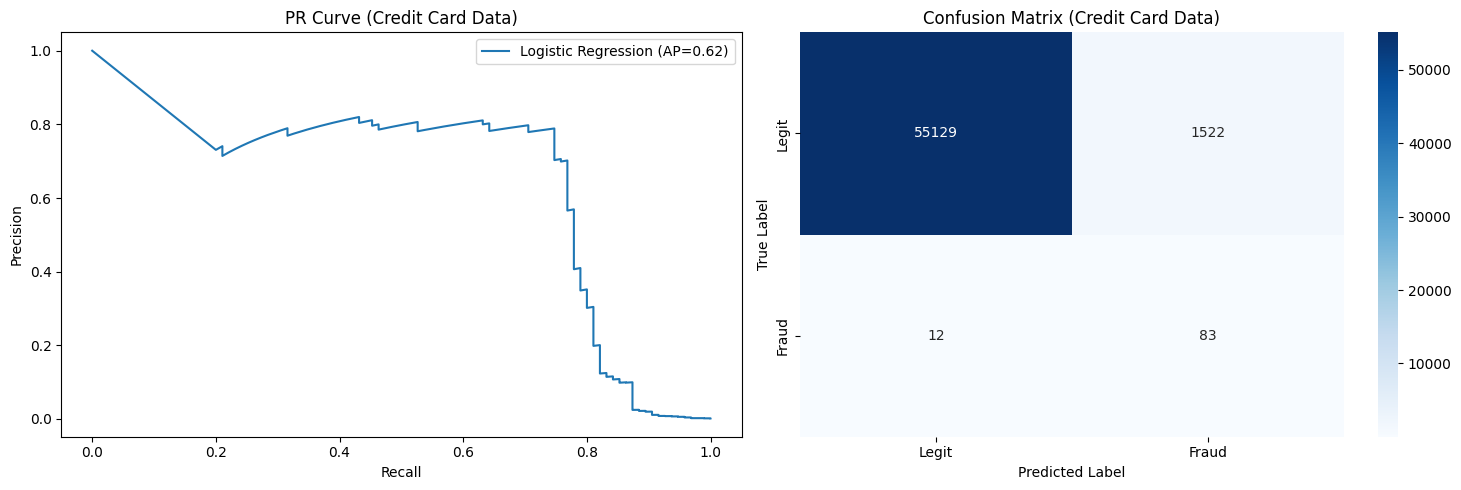


Test Set Classification Report (Logistic Regression - Credit Card Data):
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.99     56651
       Fraud       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



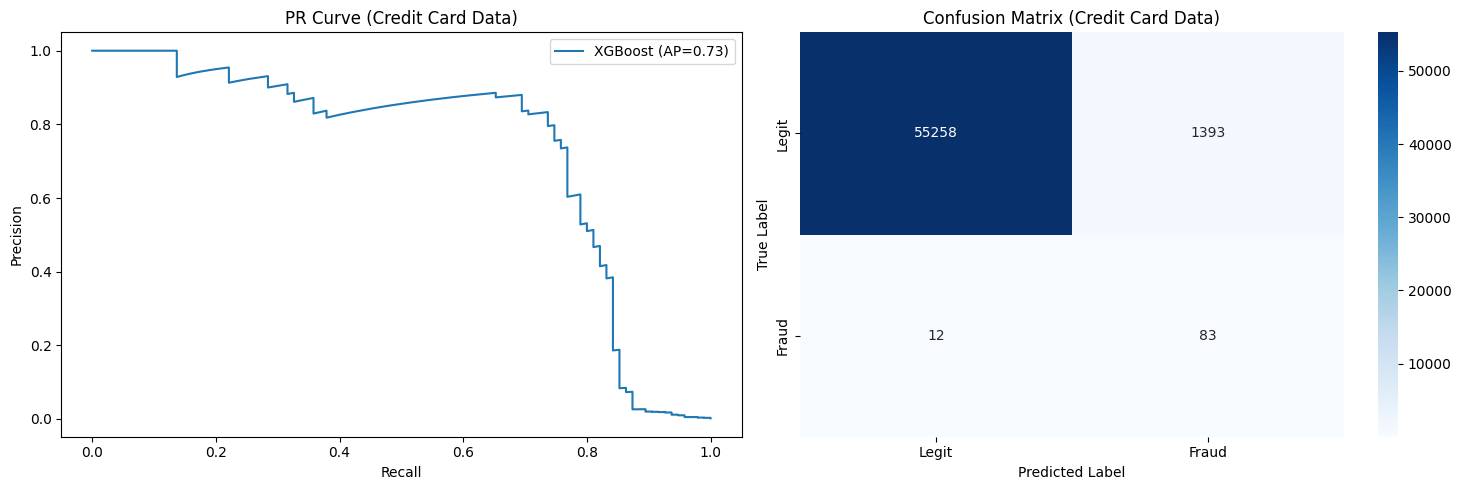


Test Set Classification Report (XGBoost - Credit Card Data):
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56651
       Fraud       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



In [8]:

# Final evaluations
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

print("\nFraud Data Results:")
lr_fraud_results = final_evaluation(lr_fraud, fraud_X_test, fraud_y_test,
                                  "Logistic Regression", "Fraud Data")
xgb_fraud_results = final_evaluation(xgb_fraud, fraud_X_test, fraud_y_test,
                                   "XGBoost", "Fraud Data")

print("\nCredit Card Data Results:")
lr_cc_results = final_evaluation(lr_cc, cc_X_test, cc_y_test,
                               "Logistic Regression", "Credit Card Data")
xgb_cc_results = final_evaluation(xgb_cc, cc_X_test, cc_y_test,
                                "XGBoost", "Credit Card Data")


In [9]:

# 6. Save Best Models
dump(xgb_fraud, '../Data/processed/best_fraud_model.joblib')
dump(xgb_cc, '../Data/processed/best_cc_model.joblib')
print("\nBest models saved to disk")


Best models saved to disk


In [ ]:
from scripts.shap_analyszer import shap_analysis

# Model parameters
best_params_fraud = {
    "n_estimators": 252,
    "max_depth": 8,
    "learning_rate": 0.19400372923812143,
    "subsample": 0.8978799950358755,
    "colsample_bytree": 0.7057902648625826,
    "gamma": 0.019502545482357816,
    "min_child_weight": 1}

best_params_cc = {
    "n_estimators": 300,
    "max_depth": 8,
    "learning_rate": 0.16405246147546276,
    "subsample": 0.7354474953142038,
    "colsample_bytree": 0.7679787915015344,
    "gamma": 1.400025824187118,
    "min_child_weight": 2}

# Initialize models
print("\nInitializing models...")
xgb_fraud = XGBClassifier(**best_params_fraud, random_state=42, eval_metric='logloss')
xgb_cc = XGBClassifier(**best_params_cc, random_state=42, eval_metric='logloss')

# Run SHAP analysis
print("\nRunning SHAP analysis for Fraud Data...")
shap_fraud = shap_analysis(xgb_fraud, fraud_X_train, fraud_y_train, fraud_X_test,
                          "XGBoost", "Fraud Data")

print("\nRunning SHAP analysis for Credit Card Data...")
shap_cc = shap_analysis(xgb_cc, cc_X_train, cc_y_train, cc_X_test,
                       "XGBoost", "Credit Card Data")

ModuleNotFoundError: No module named 'scripts.shap_analyszer'